# Tutorial 4: Unstructured Pruning on Bert

Pruning is a technique used to reduce the size and complexity of neural networks by removing unnecessary parameters (weights and connections) or structural components (neurons, filters, or layers). The goal is to create a smaller, more efficient model that maintains most of the original model's performance. The following benefits can be seen from pruning neural networks:

- **Reduce model size**: Deep neural networks often have millions of parameters, leading to large storage requirements.

- **Decrease inference time**: Fewer parameters mean fewer computations, resulting in faster predictions.

- **Improve generalization**: Removing unnecessary connections can help prevent overfitting.

- **Energy efficiency**: Smaller models require less energy to run, which is crucial for edge devices and mobile applications.

Structured pruning removes entire structures (e.g., channels, filters, or layers) from the network, while unstructured pruning removes individual weights or connections from the network, regardless of their location. In this tutorial, we'll build on top of Tutorial 3 by taking the quantized Bert model and running Mase's unstructured pruning pass. After pruning, we'll run further fine tuning iterations to retain sequence classification accuracy in the pruned model.

In [4]:
checkpoint = "prajjwal1/bert-tiny"
tokenizer_checkpoint = "bert-base-uncased"
dataset_name = "imdb"

## Importing the model

If you are starting from scratch, you can create a MaseGraph for Bert by running the following cell.

In [10]:
from transformers import AutoModelForSequenceClassification

from chop import MaseGraph
import chop.passes as passes

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
model.config.problem_type = "single_label_classification"

mg = MaseGraph(
    model,
    hf_input_names=[
        "input_ids",
        "attention_mask",
        "labels",
    ],
)

mg, _ = passes.init_metadata_analysis_pass(mg)
mg, _ = passes.add_common_metadata_analysis_pass(mg)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`past_key_values` were not specified as input names, but model.config.use_cache = True. Setting model.config.use_cache = False.
INFO     Getting dummy input for prajjwal1/bert-tiny.
/Users/yz10513/anaconda3/envs/mase/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


If you have previously ran the tutorial on Quantization-Aware Training (QAT), run the following cell to import the fine tuned checkpoint.

In [2]:
from pathlib import Path
from chop import MaseGraph
import torch

mg = MaseGraph.from_checkpoint(f"{Path.home()}/tutorial_3_qat")
# mg = MaseGraph.from_checkpoint(f"/vol/bitbucket/nr722/adls_group_14/tutorial_3_qat")
# mg.model.to("cuda")


## Unstructured Pruning

Before running pruning, let's evaluate the model accuracy on the IMDb dataset. If you're coming from Tutorial, this would be the same as the accuracy after Quantization Aware Training (QAT). If you've just initialized the model, this will likely be a random guess (i.e. around 50%), in which case pruning wouldn't have a significant effect on the accuracy.

In [5]:
from chop.tools import get_tokenized_dataset, get_trainer

dataset, tokenizer = get_tokenized_dataset(
    dataset=dataset_name,
    checkpoint=tokenizer_checkpoint,
    return_tokenizer=True,
)

trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

INFO     Tokenizing dataset imdb with AutoTokenizer for bert-base-uncased.
Map: 100%|██████████| 50000/50000 [00:12<00:00, 4018.52 examples/s]
/home/neil/adls/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Evaluation accuracy: 0.838


To run the pruning pass, we pass the following pruning configuration dictionary, which defines the following parameters.

- **Sparsity**: a value between 0 and 1, expressing the proportion of elements in the model that should be pruned (i.e. set to 0).

- **Method**: several pruning methods are supported, including ``Random`` and ``L1-Norm``.

- **Scope**: defines whether to consider each weight/activation tensor individually (``local``) or all tensors in the model (``global``) when obtaining statistics for pruning (e.g. absolute value threshold for pruning)

We'll start by running random pruning with local scope, at a fixed sparsity. This may be suboptimal, but in future tutorials we'll see how to find optimal pruning and quantization configurations for a given model on a specified dataset.

In [14]:
import chop.passes as passes

pruning_config = {
    "weight": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
    "activation": {
        "sparsity": 0.5,
        "method": "l1-norm",
        "scope": "local",
    },
}

mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)

INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Let's evaluate the effect of pruning on accuracy. It's likely to observe drops of around 10% or more.

In [16]:
trainer = get_trainer(
    model=mg.model,
    tokenized_dataset=dataset,
    tokenizer=tokenizer,
    evaluate_metric="accuracy",
    num_train_epochs=5,
)

# Evaluate accuracy
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

100%|██████████| 3125/3125 [04:47<00:00, 10.88it/s]

Evaluation accuracy: 0.55512


To overcome the drop in accuracy, we'll run a few finetuning epochs. This allows the model to adapt to the new pruning mask.

In [17]:
trainer.train()

  3%|▎         | 500/15625 [00:56<21:55, 11.50it/s]  

{'loss': 0.459, 'grad_norm': 1.4026139974594116, 'learning_rate': 4.8400000000000004e-05, 'epoch': 0.16}


  6%|▋         | 1001/15625 [01:36<31:03,  7.85it/s]

{'loss': 0.4056, 'grad_norm': 0.9277871251106262, 'learning_rate': 4.6800000000000006e-05, 'epoch': 0.32}


 10%|▉         | 1500/15625 [02:15<12:55, 18.21it/s]  

{'loss': 0.4219, 'grad_norm': 1.443852186203003, 'learning_rate': 4.52e-05, 'epoch': 0.48}


 13%|█▎        | 2000/15625 [02:52<34:12,  6.64it/s]  

{'loss': 0.4059, 'grad_norm': 1.2503076791763306, 'learning_rate': 4.36e-05, 'epoch': 0.64}


 16%|█▌        | 2500/15625 [03:25<11:55, 18.35it/s]  

{'loss': 0.4015, 'grad_norm': 0.6023377776145935, 'learning_rate': 4.2e-05, 'epoch': 0.8}


 19%|█▉        | 3000/15625 [03:53<11:18, 18.61it/s]

{'loss': 0.4032, 'grad_norm': 1.3447505235671997, 'learning_rate': 4.0400000000000006e-05, 'epoch': 0.96}


 22%|██▏       | 3501/15625 [04:20<12:08, 16.64it/s]

{'loss': 0.4193, 'grad_norm': 0.6158122420310974, 'learning_rate': 3.88e-05, 'epoch': 1.12}


 26%|██▌       | 4002/15625 [04:46<12:50, 15.09it/s]

{'loss': 0.4004, 'grad_norm': 1.2009944915771484, 'learning_rate': 3.72e-05, 'epoch': 1.28}


 29%|██▉       | 4503/15625 [05:16<10:15, 18.07it/s]

{'loss': 0.3783, 'grad_norm': 0.8180735111236572, 'learning_rate': 3.56e-05, 'epoch': 1.44}


 32%|███▏      | 5002/15625 [05:44<10:17, 17.21it/s]

{'loss': 0.3933, 'grad_norm': 0.59749835729599, 'learning_rate': 3.4000000000000007e-05, 'epoch': 1.6}


 35%|███▌      | 5502/15625 [06:12<11:11, 15.07it/s]

{'loss': 0.3883, 'grad_norm': 0.9686317443847656, 'learning_rate': 3.24e-05, 'epoch': 1.76}


 38%|███▊      | 6002/15625 [06:41<09:48, 16.35it/s]  

{'loss': 0.3871, 'grad_norm': 1.6825438737869263, 'learning_rate': 3.08e-05, 'epoch': 1.92}


 42%|████▏     | 6503/15625 [07:08<08:24, 18.08it/s]

{'loss': 0.3808, 'grad_norm': 1.0123984813690186, 'learning_rate': 2.9199999999999998e-05, 'epoch': 2.08}


 45%|████▍     | 7001/15625 [07:33<08:33, 16.79it/s]

{'loss': 0.3938, 'grad_norm': 0.5268100500106812, 'learning_rate': 2.7600000000000003e-05, 'epoch': 2.24}


 48%|████▊     | 7502/15625 [08:01<07:36, 17.81it/s]

{'loss': 0.391, 'grad_norm': 0.721001148223877, 'learning_rate': 2.6000000000000002e-05, 'epoch': 2.4}


 51%|█████     | 8001/15625 [08:27<08:42, 14.59it/s]

{'loss': 0.3842, 'grad_norm': 0.9280937314033508, 'learning_rate': 2.44e-05, 'epoch': 2.56}


 54%|█████▍    | 8502/15625 [08:52<07:08, 16.61it/s]

{'loss': 0.4128, 'grad_norm': 1.1052242517471313, 'learning_rate': 2.2800000000000002e-05, 'epoch': 2.72}


 58%|█████▊    | 9003/15625 [09:20<05:59, 18.43it/s]

{'loss': 0.379, 'grad_norm': 0.6635761260986328, 'learning_rate': 2.12e-05, 'epoch': 2.88}


 61%|██████    | 9502/15625 [09:46<05:28, 18.65it/s]

{'loss': 0.3885, 'grad_norm': 1.7871322631835938, 'learning_rate': 1.9600000000000002e-05, 'epoch': 3.04}


 64%|██████▍   | 10002/15625 [10:11<05:16, 17.76it/s]

{'loss': 0.3713, 'grad_norm': 1.0901461839675903, 'learning_rate': 1.8e-05, 'epoch': 3.2}


 67%|██████▋   | 10502/15625 [10:36<04:28, 19.10it/s]

{'loss': 0.389, 'grad_norm': 0.6938749551773071, 'learning_rate': 1.6400000000000002e-05, 'epoch': 3.36}


 70%|███████   | 11003/15625 [11:02<04:19, 17.79it/s]

{'loss': 0.3849, 'grad_norm': 0.6419057250022888, 'learning_rate': 1.48e-05, 'epoch': 3.52}


 74%|███████▎  | 11502/15625 [11:33<04:09, 16.54it/s]

{'loss': 0.3755, 'grad_norm': 0.9091131687164307, 'learning_rate': 1.32e-05, 'epoch': 3.68}


 77%|███████▋  | 12001/15625 [11:58<03:40, 16.44it/s]

{'loss': 0.3765, 'grad_norm': 0.7711085081100464, 'learning_rate': 1.16e-05, 'epoch': 3.84}


 80%|████████  | 12503/15625 [12:24<02:43, 19.11it/s]

{'loss': 0.3713, 'grad_norm': 0.4314064383506775, 'learning_rate': 1e-05, 'epoch': 4.0}


 83%|████████▎ | 13001/15625 [12:51<02:35, 16.88it/s]

{'loss': 0.375, 'grad_norm': 0.8700340390205383, 'learning_rate': 8.400000000000001e-06, 'epoch': 4.16}


 86%|████████▋ | 13502/15625 [13:16<02:01, 17.52it/s]

{'loss': 0.3822, 'grad_norm': 0.7520729899406433, 'learning_rate': 6.800000000000001e-06, 'epoch': 4.32}


 90%|████████▉ | 14002/15625 [13:41<01:30, 17.97it/s]

{'loss': 0.3715, 'grad_norm': 0.5653247833251953, 'learning_rate': 5.2e-06, 'epoch': 4.48}


 93%|█████████▎| 14500/15625 [14:07<00:55, 20.33it/s]

{'loss': 0.3871, 'grad_norm': 1.1256822347640991, 'learning_rate': 3.6e-06, 'epoch': 4.64}


 96%|█████████▌| 15002/15625 [14:36<00:38, 16.01it/s]

{'loss': 0.3831, 'grad_norm': 0.8478624820709229, 'learning_rate': 2.0000000000000003e-06, 'epoch': 4.8}


 99%|█████████▉| 15502/15625 [15:02<00:06, 17.95it/s]

{'loss': 0.3749, 'grad_norm': 0.9598965644836426, 'learning_rate': 4.0000000000000003e-07, 'epoch': 4.96}


100%|██████████| 15625/15625 [15:08<00:00, 17.20it/s]

{'train_runtime': 908.3575, 'train_samples_per_second': 137.611, 'train_steps_per_second': 17.201, 'train_loss': 0.3912585158691406, 'epoch': 5.0}


TrainOutput(global_step=15625, training_loss=0.3912585158691406, metrics={'train_runtime': 908.3575, 'train_samples_per_second': 137.611, 'train_steps_per_second': 17.201, 'total_flos': 0.0, 'train_loss': 0.3912585158691406, 'epoch': 5.0})

Let's evaluate the model accuracy after finetuning. We should see that the accuracy is reverted back to the original level.

In [18]:
eval_results = trainer.evaluate()
print(f"Evaluation accuracy: {eval_results['eval_accuracy']}")

100%|██████████| 3125/3125 [02:02<00:00, 25.45it/s]

Evaluation accuracy: 0.83624


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/vol/bitbucket/nr722/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in ver

Step,Training Loss
500,0.459800
1000,0.436300
1500,0.442800
2000,0.423700
2500,0.420800
3000,0.433000
3500,0.434300
4000,0.422000
4500,0.409200
5000,0.411700


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.1, Method: random, Accuracy: 0.83564


/vol/bitbucket/nr722/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.671100
1000,0.588700
1500,0.531800
2000,0.502900
2500,0.498900
3000,0.482400
3500,0.494400
4000,0.461200
4500,0.468700
5000,0.458000


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.3, Method: random, Accuracy: 0.80408


/vol/bitbucket/nr722/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693400
1000,0.692900
1500,0.693200
2000,0.692600
2500,0.691900
3000,0.691900
3500,0.689600
4000,0.688300
4500,0.688600
5000,0.686200


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.5, Method: random, Accuracy: 0.73232


/vol/bitbucket/nr722/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693800
1000,0.693400
1500,0.693300
2000,0.693000
2500,0.692900
3000,0.693100
3500,0.693900
4000,0.692700
4500,0.693100
5000,0.692900


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.7, Method: random, Accuracy: 0.5046


/vol/bitbucket/nr722/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.693100
1000,0.693100
1500,0.693200
2000,0.693200
2500,0.693100
3000,0.693200
3500,0.693200
4000,0.693100
4500,0.693200
5000,0.693100


Sparsity: 0.9, Method: random, Accuracy: 0.50424


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier
/vol/bitbucket/nr722/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in ver

Step,Training Loss
500,0.397700
1000,0.392100
1500,0.411300
2000,0.395500
2500,0.388200
3000,0.397600
3500,0.398600
4000,0.376900
4500,0.368500
5000,0.375800


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.1, Method: l1-norm, Accuracy: 0.85556


/vol/bitbucket/nr722/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.400100
1000,0.394100
1500,0.407200
2000,0.393900
2500,0.388900
3000,0.393500
3500,0.407400
4000,0.378700
4500,0.372000
5000,0.374600


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.3, Method: l1-norm, Accuracy: 0.84988


/vol/bitbucket/nr722/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.455800
1000,0.414500
1500,0.427700
2000,0.411600
2500,0.406900
3000,0.413800
3500,0.423000
4000,0.402500
4500,0.394000
5000,0.389800


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.5, Method: l1-norm, Accuracy: 0.8302


/vol/bitbucket/nr722/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.646900
1000,0.593400
1500,0.563100
2000,0.522700
2500,0.495700
3000,0.469700
3500,0.472600
4000,0.452000
4500,0.445000
5000,0.445200


INFO     Pruning module: bert_encoder_layer_0_attention_self_query
INFO     Pruning module: bert_encoder_layer_0_attention_self_key
INFO     Pruning module: bert_encoder_layer_0_attention_self_value
INFO     Pruning module: bert_encoder_layer_0_attention_output_dense
INFO     Pruning module: bert_encoder_layer_0_intermediate_dense
INFO     Pruning module: bert_encoder_layer_0_output_dense
INFO     Pruning module: bert_encoder_layer_1_attention_self_query
INFO     Pruning module: bert_encoder_layer_1_attention_self_key
INFO     Pruning module: bert_encoder_layer_1_attention_self_value
INFO     Pruning module: bert_encoder_layer_1_attention_output_dense
INFO     Pruning module: bert_encoder_layer_1_intermediate_dense
INFO     Pruning module: bert_encoder_layer_1_output_dense
INFO     Pruning module: bert_pooler_dense
INFO     Pruning module: classifier


Sparsity: 0.7, Method: l1-norm, Accuracy: 0.8058


/vol/bitbucket/nr722/adls_group_14/src/chop/tools/huggingface.py:157: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
500,0.692600
1000,0.692900
1500,0.693200
2000,0.693300
2500,0.694400
3000,0.692600
3500,0.693000
4000,0.692300
4500,0.693000
5000,0.692400


Sparsity: 0.9, Method: l1-norm, Accuracy: 0.54376


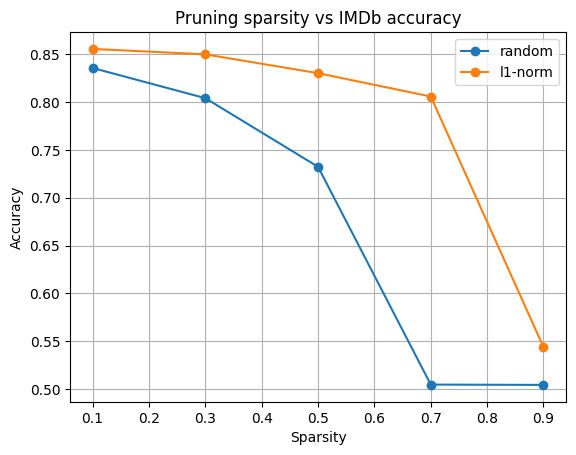

In [12]:
# Take your best obtained model from Task 1 and rerun the pruning procedure, this time varying the sparsity from 0.1 to 0.9.

# Plot a figure where the x-axis is the sparsity and the y-axis is the highest achieved accuracy on the IMDb dataset, following the procedure in Tutorial 4.

# Plot separate curves for Random and L1-Norm methods to evaluate the effect of different pruning strategies.

from pathlib import Path
from chop import MaseGraph
import chop.passes as passes
import matplotlib.pyplot as plt

methods = ["random", "l1-norm"]
sparsities = [0.1, 0.3, 0.5, 0.7, 0.9]
for method in methods:
    accuracies = []
    for sparsity in sparsities:
        mg = MaseGraph.from_checkpoint(f"/vol/bitbucket/nr722/adls_group_14/tutorial_3_qat")

        pruning_config = {
            "weight": {
                "sparsity": sparsity,
                "method": method,
                "scope": "local",
            },
            "activation": {
                "sparsity": sparsity,
                "method": method,
                "scope": "local",
            },
        }

        mg, _ = passes.prune_transform_pass(mg, pass_args=pruning_config)
        mg.model.to("cuda")
        trainer = get_trainer(
            model=mg.model,
            tokenized_dataset=dataset,
            tokenizer=tokenizer,
            evaluate_metric="accuracy",
            num_train_epochs=5,
            use_mps_device=False,
        )

        # Finetune the pruned model to recover accuracy
        trainer.train()
        eval_results = trainer.evaluate()
        accuracies.append(eval_results["eval_accuracy"])
        print(f"Sparsity: {sparsity}, Method: {method}, Accuracy: {eval_results['eval_accuracy']}")

    plt.plot(sparsities, accuracies, marker="o", label=method)

plt.xlabel("Sparsity")
plt.ylabel("Accuracy")
plt.title("Pruning sparsity vs IMDb accuracy")
plt.legend()
plt.grid(True)
plt.show()

In [13]:
print()
print(f"Method: {method}")
print("sparsities =", sparsities)
print("accuracies =", accuracies)
print("pairs =", list(zip(sparsities, accuracies)))


Method: l1-norm
sparsities = [0.1, 0.3, 0.5, 0.7, 0.9]
accuracies = [0.85556, 0.84988, 0.8302, 0.8058, 0.54376]
pairs = [(0.1, 0.85556), (0.3, 0.84988), (0.5, 0.8302), (0.7, 0.8058), (0.9, 0.54376)]
